### Creación del algoritmo genético

In [2]:
# Importamos librerías
import json
import random

In [3]:
# Definimos los parámetros para el algoritmo genético
POPULATION_SIZE = 150
MUTATION_RATE = 0.1
GENERATIONS = 10000

Para cada helado:
- 5 Sabores
- 3 Bases
- 1 Edulcorante
- 3 Topings

In [4]:
try:
    # Cargamos los datos de los ingredientes del archivo json
    with open("ingredientes.json", "r") as archivo:
        ingredientes = json.load(archivo)
except FileNotFoundError:
    raise ValueError("No se encontró el archivo especificado, asegurate de que esté dentro de la misma carpeta")

#### Definición de funciones

In [5]:
# Definimos una función para crear una población del tamaño especificado con individuos (helados) de ingredientes aleatorios
def crear_poblacion(population_size):
    poblacion = []
    for _ in range(population_size):
        helado = {
            'sabores': random.sample(list(ingredientes["sabores_helado"].keys()), 5),
            'bases': random.sample(list(ingredientes["bases_helado"].keys()), 3),
            'edulcorante': random.choice(list(ingredientes["edulcorantes_helados"].keys())),
            'toppings': random.sample(list(ingredientes["toppings_siropes_helados"].keys()), 3)
        }
        poblacion.append(helado)
    return poblacion

In [6]:
# Definimos una función fitness para evaluar los helados según la puntuación que den en la suma de su sabor, textura y novedad
def fitness(helado):
    individuo = []
    individuo.extend(helado["sabores"])
    individuo.extend(helado["bases"])
    individuo.append(helado["edulcorante"])
    individuo.extend(helado["toppings"])

    sabores = []
    textura = []
    novedad = []

    for clave in ingredientes.keys():
        for ingrediente in individuo:
            if ingrediente in ingredientes[clave]:
                sabores.append(ingredientes[clave][ingrediente]["Sabor"])
                textura.append(ingredientes[clave][ingrediente]["Textura"])
                novedad.append(ingredientes[clave][ingrediente]["Novedad"])

    sabor_total = sum(sabores)
    textura_total = sum(textura)
    novedad_total = sum(novedad)

    return sabor_total + textura_total + novedad_total # El máximo teórico es de 12(ingredientes por helado) * 30(máximo sabor, textura y novedad) = 360

In [7]:
# Definimos una función de selección que ordena una población dada en orden descendente según el fitness de cada helado
def selection(poblacion):
    poblacion_ordenada = sorted(poblacion, key=lambda x: fitness(x), reverse=True)

    return poblacion_ordenada[:POPULATION_SIZE+1] # Esta limitación de tamaño es necesaria ya que al crear nuevas generaciones las estoy rebasando la población existente para luego acotarla con un selection

In [8]:
# Definimos la función de mutación
def mutation(individuo):
    # Asocio los atributos del helado con los atributos de la tabla de ingredientes del archivo json
    atributos = [('sabores', 'sabores_helado'), ('bases', 'bases_helado'), ('edulcorante', 'edulcorantes_helados'), ('toppings', 'toppings_siropes_helados')]

    if random.random() < MUTATION_RATE: # Si se cumple la probabilidad
        atributo_mutar = random.choice(atributos) # Elige un atributo aleatorio para mutar del helado

        if atributo_mutar[0] != 'edulcorante': # El edulcorante no muta ya que al ser un sólo ingrediente de esta categoría y al estar intentando maximizar sus características, la propia selección se encarga de elegir el mejor

            ingrediente = random.choice(individuo[atributo_mutar[0]]) # Elige un ingrediente aleatorio del helado para cambiar
            ingrediente_mutado = random.choice(list(set(ingredientes[atributo_mutar[1]]) - set(individuo[atributo_mutar[0]]))) # Elige un ingrediente, no contenido ya en el helado, aleatorio de la misma característica que el ingrediente a cambiar para reemplazarlo

            individuo[atributo_mutar[0]] = [ingrediente_mutado if sabor == ingrediente else sabor for sabor in individuo[atributo_mutar[0]]] # Reemplaza el ingrediente por el ingrediente mutado

    return individuo

In [9]:
# Definimos una función de cruzamiento que crea un helado("hijo") que herede de dos helados("padres") ingredientes de estos de forma aleatoria
def crossover(parent1, parent2):
    child = {
        'sabores': random.sample(list(set(parent1['sabores']).union(set(parent2['sabores']))), 5),
        'bases': random.sample(list(set(parent1['bases']).union(set(parent2['bases']))), 3),
        'edulcorante': random.choice([parent1['edulcorante'], parent2['edulcorante']]),
        'toppings': random.sample(list(set(parent1['toppings']).union(set(parent2['toppings']))), 3)
    }
    return child

In [10]:
# Definimos la función de algoritmo genético
def genetic_algorithm(population_size=POPULATION_SIZE, generations=GENERATIONS, mutation_rate=MUTATION_RATE):
    poblacion = crear_poblacion(population_size) # Creamos una población inicial

    for _ in range(generations): # Creamos nuevas generaciones y modificamos la población
        poblacion = selection(poblacion)
        nueva_generacion = []

        for _ in range(population_size): # Cruzamos ejemplares aleatorios de la población para dar paso a nuevas generaciones
            padre1, padre2 = random.choices(poblacion, k=2)
            hijo = crossover(padre1, padre2)
            nueva_generacion.append(hijo)

        poblacion = poblacion + nueva_generacion # Rebasamos la población existente con la nueva generación para luego acotarlas al tamaño de la población deseado en la siguiente iteración del bucle
        poblacion = [mutation(helado) for helado in poblacion] # Iteramos la lista de la población con la función mutation para que muten los individuos que caigan dentro de la probabilidad de mutación

    mejor_individuo = max(poblacion, key=lambda x: fitness(x))

    return mejor_individuo, fitness(mejor_individuo)

### Ajuste de hiperparámetros para el algoritmo

En vez de aumentar muchos los hiperparámetros, aumentando a su vez el coste computacional, para obtener una respuesta lo más determinista y máxima posible siempre que lo ejecute, voy a ajustar los hiperparámetros para que me de una respuesta rápida muy buena.

In [11]:
import time # Importamos la librería time para calcular el tiempo de ejecución con los parámetros originales
import numpy as np

In [12]:
t0 = time.time()
print(genetic_algorithm(POPULATION_SIZE))
tf = time.time()

print(f"El algoritmo ha tardado: {round(tf-t0, 2)}s en ejecutarse.")  # Inicialmente está tardando 39,56s en ejecutarse.

({'sabores': ['Almendra', 'Yogur', 'Naranja x', 'Sandía', 'Dulce de membrillo'], 'bases': ['Fruta', 'Yogur', 'Leche de almendras'], 'edulcorante': 'Maltitol', 'toppings': ['Salsa de mango', 'Pepitas de chocolate', 'Trozos de oreo']}, 299.44)
El algoritmo ha tardado: 40.87s en ejecutarse.


Con los datos iniciales que le he puesto para los hiperparámetros tarda 39,56 segundos y me da siempre un fitness, que es el máximo, de 299,44.

In [13]:
# Probamos con distintos parámetros hasta llegar al siguiente resultado aceptable:
POPULATION_SIZE = 150
MUTATION_RATE = 0.1
GENERATIONS = 100

Le he reducido el número de generaciones de 10000 a 100. Ahora ejecutamos el siguiente código para comprobar la media de cuánto tarda en ejecturse y si el fitness es aceptable.

In [14]:
tiempos = []
fitness_max = []
for _ in range(20):
    t0 = time.time()
    fitness_max.append(genetic_algorithm(population_size=POPULATION_SIZE, generations=100)[1])
    tf = time.time()
    tiempos.append(round(tf-t0, 2))

print(f"La media de tiempo de ejecución ha sido de: {np.mean(tiempos)}s en ejecutarse.")
print(f"El fitness máximo ha sido de: {np.max(fitness_max)}, el más bajo de: {np.min(fitness_max)} y el fitness promedio de: {np.average(fitness_max)}.")

La media de tiempo de ejecución ha sido de: 0.4835s en ejecutarse.
El fitness máximo ha sido de: 299.44, el más bajo de: 299.35 y el fitness promedio de: 299.43549999999993.


Como podemos apreciar, el fitness que nos está dando es el máximo y en la peor situación se acerca muchísimo a este. Por lo que con un tiempo medio de ejecución de 0,43 segundos, doy por concluido el proceso de ajustes del hiperparámetro.

### Estudio gráfico de los ingredientes

Ahora mediante la librería pandas crearemos un dataframe por cada categoría para obtener los ingredientes con mayor fitness por categoría.
Al juntar los ingredientes con mayor fitness deberán coincidir con los ingredientes del mejor helado que calcule nuestro algoritmo, ya que al ser una algoritmo de Maximización, el helado estará compuesto por los ingredientes con mayor fitness.

In [15]:
import pandas as pd 

df_sabores = pd.DataFrame(ingredientes["sabores_helado"]) # DataFrame categoría sabores
df_sabores = df_sabores.transpose()

df_bases_helado = pd.DataFrame(ingredientes["bases_helado"]) # DataFrame categoría sabores
df_bases_helado = df_bases_helado.transpose()

df_edulcorantes_helados = pd.DataFrame(ingredientes["edulcorantes_helados"]) # DataFrame categoría sabores
df_edulcorantes_helados = df_edulcorantes_helados.transpose()

df_toppings_siropes_helados = pd.DataFrame(ingredientes["toppings_siropes_helados"]) # DataFrame categoría sabores
df_toppings_siropes_helados = df_toppings_siropes_helados.transpose()

fitness_sabores = df_sabores.sum(axis=1)
fitness_bases = df_bases_helado.sum(axis=1)
fitness_edulcorantes = df_edulcorantes_helados.sum(axis=1)
fitness_toppings = df_toppings_siropes_helados.sum(axis=1)

print("ingredientes con mayor fitness por categoría:")
print("- Sabores:")
print(fitness_sabores.nlargest(5))
print()
print("- Bases:")
print(fitness_bases.nlargest(5))
print()
print("- Edulcorantes:")
print(fitness_edulcorantes.nlargest(5))
print()
print("- Toppings & Siropes:")
print(fitness_toppings.nlargest(5))

ingredientes con mayor fitness por categoría:
- Sabores:
Naranja x             25.82
Dulce de membrillo    25.52
Almendra              24.93
Sandía                24.24
Mandarina verde       23.82
dtype: float64

- Bases:
Leche de almendras     23.41
Fruta                  22.74
Leche de soja          20.00
Crema de leche         19.50
Plátanos congelados    16.16
dtype: float64

- Edulcorantes:
Maltitol          25.70
Jarabe de maíz    21.92
Miel              21.60
Aspartamo         21.39
Sorbitol          15.63
dtype: float64

- Toppings & Siropes:
Salsa de mango               24.82
Trozos de oreo               24.51
Pepitas de chocolate         24.35
Fresas frescas               21.87
Sirope de fresa silvestre    21.18
dtype: float64


Para obtener los ingredientes que tienen mayor fitness en promedio independientemente de la categoría, podemos juntar los dataframes por categoría y cojer los 10 mejores.

In [42]:
df = pd.concat([fitness_sabores.nlargest(5), fitness_bases.nlargest(5), fitness_edulcorantes.nlargest(5), fitness_toppings.nlargest(5)])

df.nlargest(10)

Naranja x               25.82
Maltitol                25.70
Dulce de membrillo      25.52
Almendra                24.93
Salsa de mango          24.82
Trozos de oreo          24.51
Pepitas de chocolate    24.35
Sandía                  24.24
Mandarina verde         23.82
Leche de almendras      23.41
dtype: float64

Ahora que hemos hecho el estudio con pandas de los ingredientes con mayor fitness, podemos compararlo con los ingredientes que están presentes en el mejor helado que nos da el algoritmo genético y como podemos ver en las siguientes líneas coinciden, por lo que nuestro algoritmo genético hace un buen trabajo.

Podemos obtener los ingredientes que en promedio tienen mayor fitness cogiendo los ingredientes del mejor individuo de nuestra población final del agoritmo genético.

In [16]:
mejor_helado, fitness_mejor = genetic_algorithm(generations=100)

Ahora podemos reutilizar parte del código de la función fitness para calcular el fitness individual de cada ingrediente.

In [17]:
# Definimos una función fitness para evaluar los helados según la puntuación que den en la suma de su sabor, textura y novedad
def fitness_ingrediente(helado):
    individuo = []
    individuo.extend(helado["sabores"])
    individuo.extend(helado["bases"])
    individuo.append(helado["edulcorante"])
    individuo.extend(helado["toppings"])

    for clave in ingredientes.keys():
        for ingrediente in individuo:
            if ingrediente in ingredientes[clave]:
                fitness_ingrediente = round(sum([ingredientes[clave][ingrediente]["Sabor"], ingredientes[clave][ingrediente]["Textura"], ingredientes[clave][ingrediente]["Novedad"]]), 2)
                print(f"- {ingrediente}: {fitness_ingrediente}")

    # return sabor_total + textura_total + novedad_total # El máximo teórico es de 12(ingredientes por helado) * 30(máximo sabor, textura y novedad) = 360

Estos son los ingredientes que tienen mayor fitness:

In [18]:
fitness_ingrediente(mejor_helado)

- Yogur: 17.38
- Miel: 2.55
- Dulce de membrillo: 25.52
- Naranja x: 25.82
- Almendra: 24.93
- Yogur: 17.38
- Yogur: 9.32
- Leche de almendras: 23.41
- Yogur: 9.32
- Fruta: 22.74
- Miel: 21.6
- Maltitol: 25.7
- Trozos de oreo: 24.51
- Salsa de mango: 24.82
- Pepitas de chocolate: 24.35


Como podemos ver en la lista de arriba, los ingredientes que hemos calculado con mayor fitness están presentes en los ingredientes del mejor helado.

Distribución del fitness en los individuos de la población inicial.

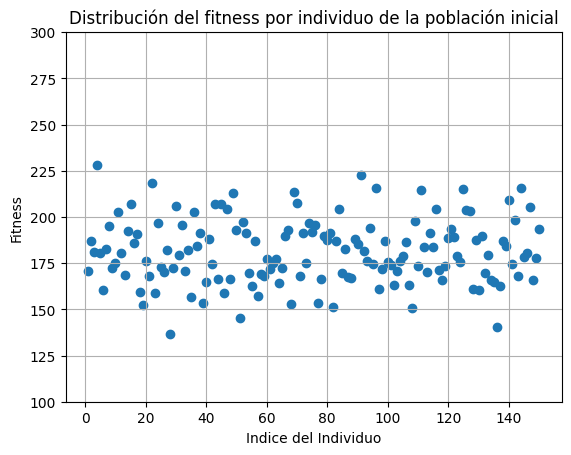

In [19]:
import matplotlib.pyplot as plt

poblacion = crear_poblacion(population_size=150)
fitness_individuo = [fitness(individuo) for individuo in poblacion]

plt.scatter(np.arange(1, 151), fitness_individuo)

plt.title("Distribución del fitness por individuo de la población inicial")

# plt.ylim(0, 300)
plt.ylim(100, 300)
plt.xlabel("Indice del Individuo")
plt.ylabel("Fitness")
plt.grid(True)
plt.show()

Los ingredientes que se encuentran con mayor frecuencia en los individuos de mayor fitness coincidiran con los que tienen mayor fitness (que ya hemos calculado) y por tanto con los que tenga el mejor individuo que calcule nuestro algoritmo genético.

In [20]:
fitness_ingrediente(genetic_algorithm(generations=100)[0])

- Sandía: 24.24
- Yogur: 17.38
- Naranja x: 25.82
- Almendra: 24.93
- Dulce de membrillo: 25.52
- Yogur: 17.38
- Yogur: 9.32
- Leche de almendras: 23.41
- Fruta: 22.74
- Yogur: 9.32
- Maltitol: 25.7
- Trozos de oreo: 24.51
- Pepitas de chocolate: 24.35
- Salsa de mango: 24.82


### Graficando el funcionamiento del algoritmo genético

In [21]:
import matplotlib.pyplot as plt
import numpy as np

In [22]:
# Definimos la función de algoritmo genético
def genetic_algorithm(population_size=POPULATION_SIZE, mutation_rate=MUTATION_RATE, generations=GENERATIONS, verbose=False):
    max_fitness_values = []
    min_fitness_values = []

    poblacion = crear_poblacion(population_size) # Creamos una población inicial

    for _ in range(generations): # Creamos nuevas generaciones y modificamos la población
        poblacion = selection(poblacion)
        nueva_generacion = []

        for _ in range(population_size): # Cruzamos ejemplares aleatorios de la población para dar paso a nuevas generaciones
            padre1, padre2 = random.choices(poblacion, k=2)
            hijo = crossover(padre1, padre2)
            nueva_generacion.append(hijo)

        poblacion = poblacion + nueva_generacion # Rebasamos la población existente con la nueva generación para luego acotarlas al tamaño de la población deseado en la siguiente iteración del bucle
        poblacion = [mutation(helado) for helado in poblacion] # Iteramos la lista de la población con la función mutation para que muten los individuos que caigan dentro de la probabilidad de mutación
        
        mejor_individuo = max(poblacion, key=lambda x: fitness(x))
        peor_individuo = min(poblacion, key=lambda x: fitness(x))

        max_fitness_values.append(fitness(mejor_individuo))
        min_fitness_values.append(fitness(peor_individuo))

    mejor_individuo = max(poblacion, key=lambda x: fitness(x))

    plt.plot(np.arange(0, len(max_fitness_values)), max_fitness_values, color="orange", label="Fitness máximo")
    plt.title("Fitness máximo y mínimo de cada generación generación", fontdict={'fontsize': 14})
    plt.xlabel("Nº de Generaciones")
    plt.ylabel("Valor del Fitness")
    plt.plot(min_fitness_values, color="turquoise", label="Fitness mínimo")
    plt.legend()
    plt.grid(visible=True, which="both")
    plt.minorticks_on()
    plt.show()

    return mejor_individuo, fitness(mejor_individuo)

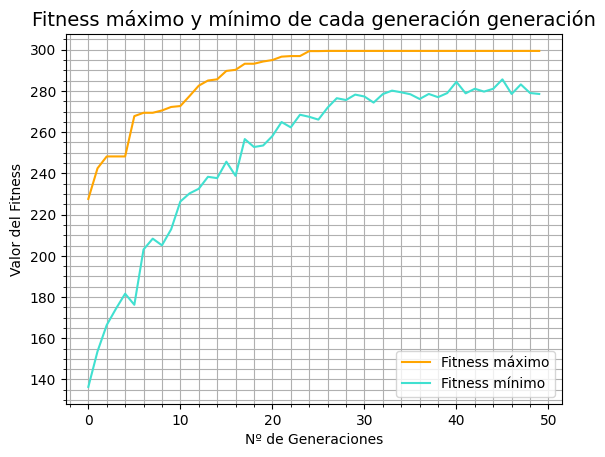

({'sabores': ['Yogur', 'Sandía', 'Naranja x', 'Almendra', 'Dulce de membrillo'], 'bases': ['Fruta', 'Leche de almendras', 'Yogur'], 'edulcorante': 'Maltitol', 'toppings': ['Trozos de oreo', 'Pepitas de chocolate', 'Salsa de mango']}, 299.44)


In [23]:
print(genetic_algorithm(population_size=POPULATION_SIZE, generations=50))

Viendo de manera visual cuál es la evolución del individuo máximo y mínimo de cada población, podemos observar como con cada generación se van incrementando hasta convergir en torno a la generación 25, como es propio de nuestro algoritmo de maximización. Al converger siempre antes de la generación número 30, podemos decidir como ajuste correcto del hiperparámetro que el algoritmo se ejecute siempre para 30 generaciones.

A su vez, podemos determinar como ya habíamos llegado a la conclusión antes mediante la medición de tiempos cambiando los distintos parámetros del algoritmo genético, que lo que más influye a nivel computacional en el algoritmo es el número de generaciones.

In [24]:
# Definimos la función de algoritmo genético
def genetic_algorithm(population_size=POPULATION_SIZE, mutation_rate=MUTATION_RATE, generations=GENERATIONS, verbose=False):
    avg_fitness_values = []

    poblacion = crear_poblacion(population_size) # Creamos una población inicial

    for _ in range(generations): # Creamos nuevas generaciones y modificamos la población
        promedio_generacion = []
        poblacion = selection(poblacion)
        nueva_generacion = []

        for _ in range(population_size): # Cruzamos ejemplares aleatorios de la población para dar paso a nuevas generaciones
            padre1, padre2 = random.choices(poblacion, k=2)
            hijo = crossover(padre1, padre2)
            nueva_generacion.append(hijo)

        poblacion = poblacion + nueva_generacion # Rebasamos la población existente con la nueva generación para luego acotarlas al tamaño de la población deseado en la siguiente iteración del bucle
        poblacion = [mutation(helado) for helado in poblacion] # Iteramos la lista de la población con la función mutation para que muten los individuos que caigan dentro de la probabilidad de mutación
        
        promedio_individuos = max(poblacion, key=lambda x: fitness(x))
        for individuo in poblacion:
            promedio_generacion.append(fitness(individuo))
        avg_fitness_values.append(np.mean(promedio_generacion))


    mejor_individuo = max(poblacion, key=lambda x: fitness(x))

    plt.plot(np.arange(0, len(avg_fitness_values)), avg_fitness_values, color="orange", label="Fitness promedio")
    plt.legend()
    plt.grid(visible=True, which="both")
    plt.minorticks_on()
    plt.show()

    return mejor_individuo, fitness(mejor_individuo)

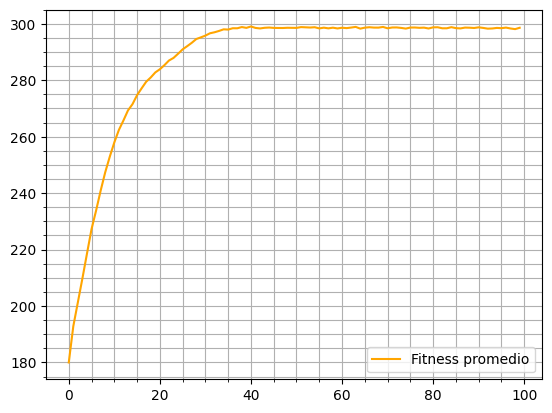

({'sabores': ['Sandía',
   'Almendra',
   'Yogur',
   'Dulce de membrillo',
   'Naranja x'],
  'bases': ['Yogur', 'Leche de almendras', 'Fruta'],
  'edulcorante': 'Maltitol',
  'toppings': ['Trozos de oreo', 'Salsa de mango', 'Pepitas de chocolate']},
 299.44)

In [25]:
genetic_algorithm()

En esta gráfica podemos observar el fitness promedio del fitness de los individuos en cada generación.

### Tasa de supervivencia de los ingredientes

Para graficar la tasa de supervivencia de los ingredientes de la población en función de cada generación, estoy modificando el algoritmo genético.

In [26]:
def genetic_algorithm(population_size=150, generations=GENERATIONS):
    poblacion = crear_poblacion(population_size)  # Creamos una población inicial

    # Inicializamos el diccionario para registrar la frecuencia de los ingredientes
    ingrediente_frecuencia = {ingrediente: [] for categoria in ingredientes.values() for ingrediente in categoria}

    for generation in range(generations):  # Creamos nuevas generaciones y modificamos la población
        poblacion = selection(poblacion)
        nueva_generacion = []

        for _ in range(population_size):  # Cruzamos ejemplares aleatorios de la población para dar paso a nuevas generaciones
            padre1, padre2 = random.choices(poblacion, k=2)
            hijo = crossover(padre1, padre2)
            nueva_generacion.append(hijo)

        poblacion = poblacion + nueva_generacion  # Rebasamos la población existente con la nueva generación para luego acotarlas al tamaño de la población deseado en la siguiente iteración del bucle
        poblacion = [mutation(helado) for helado in poblacion]  # Iteramos la lista de la población con la función mutation para que muten los individuos que caigan dentro de la probabilidad de mutación

        # Contamos la frecuencia de cada ingrediente en la población actual
        contador = {ingrediente: 0 for categoria in ingredientes.values() for ingrediente in categoria}
        for helado in poblacion:
            for categoria in helado.values():
                if isinstance(categoria, list):
                    for item in categoria:
                        contador[item] += 1
                else:
                    contador[categoria] += 1

        # Guardamos las frecuencias normalizadas
        for ingrediente in contador:
            ingrediente_frecuencia[ingrediente].append(contador[ingrediente] / (population_size * 2))  # Normalizado por el tamaño de la población y las combinaciones

    mejor_individuo = max(poblacion, key=lambda x: fitness(x))

    # Graficamos la frecuencia de los ingredientes
    plt.figure(figsize=(12, 6))
    for ingrediente, frecuencias in ingrediente_frecuencia.items():
        plt.plot(frecuencias, label=ingrediente)
    plt.legend()
    plt.xlabel('Generaciones')
    plt.ylabel('Frecuencia')
    plt.title('Frecuencia de los Ingredientes a lo largo de las Generaciones')
    plt.show()

    # Imprimimos los ingredientes que más se repiten
    total_frecuencia = {ingrediente: sum(frecuencias) for ingrediente, frecuencias in ingrediente_frecuencia.items()}
    ingredientes_mas_frecuentes = sorted(total_frecuencia.items(), key=lambda x: x[1], reverse=True)

    print("Ingredientes más frecuentes:")
    for ingrediente, frecuencia in ingredientes_mas_frecuentes[:10]:  # Top 10 ingredientes más frecuentes
        print(f"{ingrediente}: {frecuencia}")

    return mejor_individuo, fitness(mejor_individuo)

Debido a que estamos creando la población mediante un random.sample, lo que hace que nos retorna ingredientes sin poderse repetir a futuro, al haber llegado a este punto, hemos creado tantas poblaciones que para que funcione el siguiente algoritmo al ejecutarlo, vamos a necesitar volver a ejecutar la función de crear población para reiniciar el random.sample.

In [27]:
# Definimos una función para crear una población del tamaño especificado con individuos (helados) de ingredientes aleatorios
def crear_poblacion(population_size):
    poblacion = []
    for _ in range(population_size):
        helado = {
            'sabores': random.sample(list(ingredientes["sabores_helado"].keys()), 5),
            'bases': random.sample(list(ingredientes["bases_helado"].keys()), 3),
            'edulcorante': random.choice(list(ingredientes["edulcorantes_helados"].keys())),
            'toppings': random.sample(list(ingredientes["toppings_siropes_helados"].keys()), 3)
        }
        poblacion.append(helado)
    return poblacion

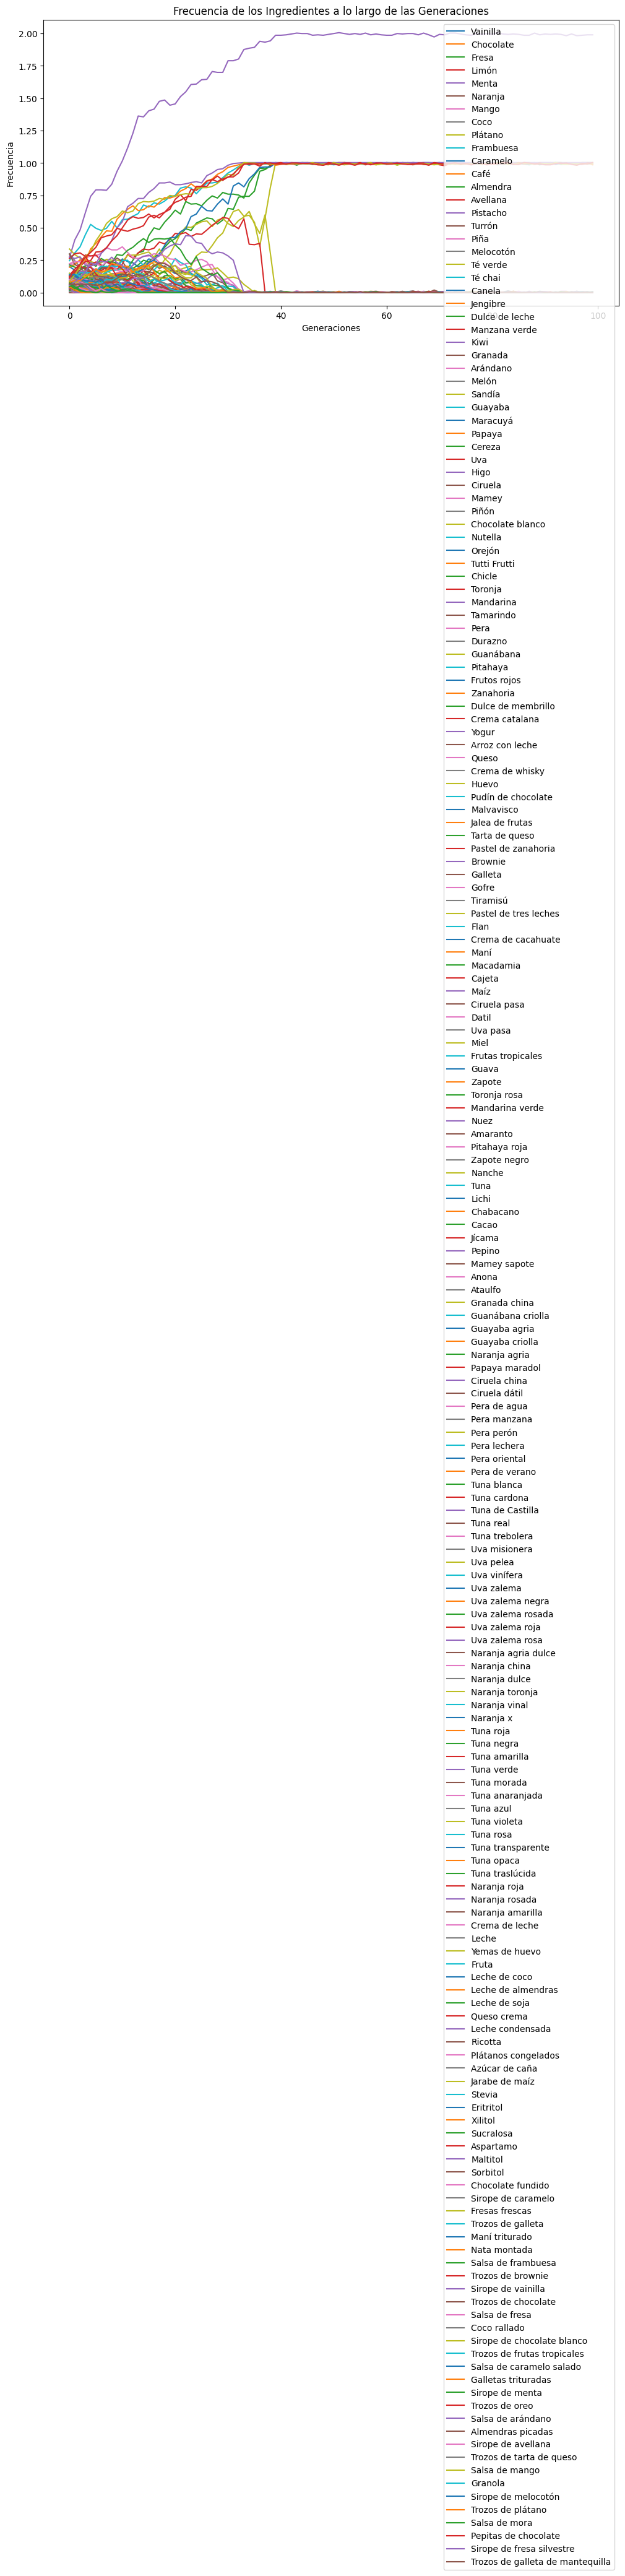

Ingredientes más frecuentes:
Yogur: 174.60666666666665
Maltitol: 88.98333333333333
Fruta: 88.61
Leche de almendras: 88.29
Salsa de mango: 87.85666666666667
Trozos de oreo: 86.11
Pepitas de chocolate: 86.07333333333334
Dulce de membrillo: 79.88
Naranja x: 77.76
Almendra: 76.66


({'sabores': ['Sandía',
   'Dulce de membrillo',
   'Naranja x',
   'Yogur',
   'Almendra'],
  'bases': ['Leche de almendras', 'Yogur', 'Fruta'],
  'edulcorante': 'Maltitol',
  'toppings': ['Trozos de oreo', 'Pepitas de chocolate', 'Salsa de mango']},
 299.44)

In [28]:
genetic_algorithm(generations=100, population_size=POPULATION_SIZE)

 Naranja x: 25.82
- Almendra: 24.93
- Sandía: 24.24
- Dulce de membrillo: 25.52
- Yogur: 17.38
- Yogur: 17.38
- Yogur: 9.32
- Yogur: 9.32
- Leche de almendras: 23.41
- Fruta: 22.74
- Maltitol: 25.7
- Trozos de oreo: 24.51
- Salsa de mango: 24.82
- Pepitas de chocolate: 24.35

## Creando un registro dentro de la función del algoritmo genético inicial

In [29]:
# Definimos la función de algoritmo genético
def genetic_algorithm(population_size=POPULATION_SIZE, generations=GENERATIONS, registro=False, verbose=False, mutation_rate=MUTATION_RATE):
    registro_poblacional = {}
    max_fitness_values = []
    min_fitness_values = []

    poblacion = crear_poblacion(population_size) # Creamos una población inicial
    # registro_poblacional[1]

    for i in range(generations): # Creamos nuevas generaciones y modificamos la población
        
        nueva_generacion = []

        for _ in range(population_size): # Cruzamos ejemplares aleatorios de la población para dar paso a nuevas generaciones
            padre1, padre2 = random.choices(poblacion, k=2)
            hijo = crossover(padre1, padre2)
            nueva_generacion.append(hijo)

        poblacion = poblacion + nueva_generacion # Rebasamos la población existente con la nueva generación para luego acotarlas al tamaño de la población deseado en la siguiente iteración del bucle
        poblacion = [mutation(helado) for helado in poblacion] # Iteramos la lista de la población con la función mutation para que muten los individuos que caigan dentro de la probabilidad de mutación
        poblacion = selection(poblacion)

        if registro == True:
            registro_poblacional[i+1] = poblacion

        if verbose == True:
            mejor_individuo = max(poblacion, key=lambda x: fitness(x))
            peor_individuo = min(poblacion, key=lambda x: fitness(x))

            max_fitness_values.append(fitness(mejor_individuo))
            min_fitness_values.append(fitness(peor_individuo))

    mejor_individuo = max(poblacion, key=lambda x: fitness(x))

    if verbose == True:
        plt.plot(np.arange(0, len(max_fitness_values)), max_fitness_values, color="orange", label="Fitness máximo")
        plt.title("Fitness máximo y mínimo de cada generación generación", fontdict={'fontsize': 14})
        plt.xlabel("Nº de Generaciones")
        plt.ylabel("Valor del Fitness")
        plt.plot(min_fitness_values, color="turquoise", label="Fitness mínimo")
        plt.legend()
        plt.grid(visible=True, which="both")
        plt.minorticks_on()
        plt.show()

    if registro == True:
        return mejor_individuo, fitness(mejor_individuo), registro_poblacional
    else:
        return mejor_individuo, fitness(mejor_individuo)

In [30]:
mejor_individuo, fitness_mejor, registro = genetic_algorithm(generations=100, registro=True)